In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [3]:
### RECEIVE 20,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [4]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
#     hp_regularizer = hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1), kernel_regularizer=regularizers.l2(hp_regularizer)))
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

    return model

In [5]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('mean_squared_error', 'min'),
                     max_epochs=25,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5)

In [6]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.15, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1779 - mean_squared_error: 0.1779 - val_loss: 0.1590 - val_mean_squared_error: 0.1590
Epoch 2/3
14450/14450 - 1s - loss: 0.1376 - mean_squared_error: 0.1376 - val_loss: 0.1185 - val_mean_squared_error: 0.1185
Epoch 3/3
14450/14450 - 1s - loss: 0.1101 - mean_squared_error: 0.1101 - val_loss: 0.1035 - val_mean_squared_error: 0.1035


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/3
14450/14450 - 1s - loss: 8.0948e-04 - mean_squared_error: 8.0948e-04 - val_loss: 4.5100e-04 - val_mean_squared_error: 4.5100e-04
Epoch 3/3
14450/14450 - 1s - loss: 4.2037e-04 - mean_squared_error: 4.2037e-04 - val_loss: 3.7431e-04 - val_mean_squared_error: 3.7431e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1640 - mean_squared_error: 0.1640 - val_loss: 0.1347 - val_mean_squared_error: 0.1347
Epoch 2/3
14450/14450 - 1s - loss: 0.1079 - mean_squared_error: 0.1079 - val_loss: 0.0830 - val_mean_squared_error: 0.0830
Epoch 3/3
14450/14450 - 1s - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0496 - val_mean_squared_error: 0.0496


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 4.6514e-04 - val_mean_squared_error: 4.6514e-04
Epoch 2/3
14450/14450 - 1s - loss: 7.1008e-04 - mean_squared_error: 7.1008e-04 - val_loss: 4.7790e-04 - val_mean_squared_error: 4.7790e-04
Epoch 3/3
14450/14450 - 1s - loss: 6.1071e-04 - mean_squared_error: 6.1071e-04 - val_loss: 5.5840e-04 - val_mean_squared_error: 5.5840e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1420 - mean_squared_error: 0.1420 - val_loss: 0.0895 - val_mean_squared_error: 0.0895
Epoch 2/3
14450/14450 - 2s - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 3/3
14450/14450 - 2s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0141 - val_mean_squared_error: 0.0141


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 7.1810e-04 - val_mean_squared_error: 7.1810e-04
Epoch 2/3
14450/14450 - 2s - loss: 4.4966e-04 - mean_squared_error: 4.4966e-04 - val_loss: 6.2841e-04 - val_mean_squared_error: 6.2841e-04
Epoch 3/3
14450/14450 - 2s - loss: 4.6841e-04 - mean_squared_error: 4.6841e-04 - val_loss: 5.3653e-04 - val_mean_squared_error: 5.3653e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 4.9479e-04 - val_mean_squared_error: 4.9479e-04
Epoch 2/3
14450/14450 - 1s - loss: 5.5302e-04 - mean_squared_error: 5.5302e-04 - val_loss: 3.9756e-04 - val_mean_squared_error: 3.9756e-04
Epoch 3/3
14450/14450 - 1s - loss: 4.6766e-04 - mean_squared_error: 4.6766e-04 - val_loss: 5.6836e-04 - val_mean_squared_error: 5.6836e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/3
14450/14450 - 1s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 5.9553e-04 - val_mean_squared_error: 5.9553e-04
Epoch 3/3
14450/14450 - 1s - loss: 5.0725e-04 - mean_squared_error: 5.0725e-04 - val_loss: 4.0259e-04 - val_mean_squared_error: 4.0259e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1149 - mean_squared_error: 0.1149 - val_loss: 0.0528 - val_mean_squared_error: 0.0528
Epoch 2/3
14450/14450 - 2s - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 3/3
14450/14450 - 2s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0034 - val_mean_squared_error: 0.0034


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/3
14450/14450 - 2s - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 0.1820 - val_mean_squared_error: 0.1820
Epoch 3/3
14450/14450 - 2s - loss: 0.2303 - mean_squared_error: 0.2303 - val_loss: 0.2202 - val_mean_squared_error: 0.2202


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 2/3
14450/14450 - 1s - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 3/3
14450/14450 - 1s - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0498 - val_mean_squared_error: 0.0498


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1165 - mean_squared_error: 0.1165 - val_loss: 0.0532 - val_mean_squared_error: 0.0532
Epoch 2/3
14450/14450 - 2s - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/3
14450/14450 - 2s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0035 - val_mean_squared_error: 0.0035


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/9
14450/14450 - 1s - loss: 7.8884e-04 - mean_squared_error: 7.8884e-04 - val_loss: 4.7490e-04 - val_mean_squared_error: 4.7490e-04
Epoch 6/9
14450/14450 - 1s - loss: 4.4139e-04 - mean_squared_error: 4.4139e-04 - val_loss: 3.8736e-04 - val_mean_squared_error: 3.8736e-04
Epoch 7/9
14450/14450 - 2s - loss: 3.8973e-04 - mean_squared_error: 3.8973e-04 - val_loss: 3.7289e-04 - val_mean_squared_error: 3.7289e-04
Epoch 8/9
14450/14450 - 2s - loss: 3.7113e-04 - mean_squared_error: 3.7113e-04 - val_loss: 4.8206e-04 - val_mean_squared_error: 4.8206e-04
Epoch 9/9
14450/14450 - 1s - loss: 3.9664e-04 - mean_squared_error: 3.9665e-04 - val_loss: 6.1450e-04 - val_mean_squared_error: 6.1450e-04


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 4.6222e-04 - val_mean_squared_error: 4.6222e-04
Epoch 5/9
14450/14450 - 2s - loss: 4.4676e-04 - mean_squared_error: 4.4676e-04 - val_loss: 4.7742e-04 - val_mean_squared_error: 4.7742e-04
Epoch 6/9
14450/14450 - 2s - loss: 4.3580e-04 - mean_squared_error: 4.3580e-04 - val_loss: 3.5854e-04 - val_mean_squared_error: 3.5854e-04
Epoch 7/9
14450/14450 - 2s - loss: 4.0962e-04 - mean_squared_error: 4.0962e-04 - val_loss: 4.2820e-04 - val_mean_squared_error: 4.2820e-04
Epoch 8/9
14450/14450 - 2s - loss: 4.0636e-04 - mean_squared_error: 4.0636e-04 - val_loss: 3.8501e-04 - val_mean_squared_error: 3.8501e-04
Epoch 9/9
14450/14450 - 2s - loss: 4.1480e-04 - mean_squared_error: 4.1480e-04 - val_loss: 4.3799e-04 - val_mean_squared_error: 4.3799e-04


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 4.2196e-04 - val_mean_squared_error: 4.2196e-04
Epoch 5/9
14450/14450 - 1s - loss: 5.2375e-04 - mean_squared_error: 5.2375e-04 - val_loss: 4.8783e-04 - val_mean_squared_error: 4.8783e-04
Epoch 6/9
14450/14450 - 1s - loss: 5.9677e-04 - mean_squared_error: 5.9677e-04 - val_loss: 3.6199e-04 - val_mean_squared_error: 3.6199e-04
Epoch 7/9
14450/14450 - 1s - loss: 5.2844e-04 - mean_squared_error: 5.2844e-04 - val_loss: 4.5458e-04 - val_mean_squared_error: 4.5458e-04
Epoch 8/9
14450/14450 - 1s - loss: 4.8339e-04 - mean_squared_error: 4.8339e-04 - val_loss: 3.8263e-04 - val_mean_squared_error: 3.8263e-04
Epoch 9/9
14450/14450 - 1s - loss: 4.7972e-04 - mean_squared_error: 4.7972e-04 - val_loss: 4.8482e-04 - val_mean_squared_error: 4.8482e-04


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 5/9
14450/14450 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.0928e-04 - val_mean_squared_error: 6.0928e-04
Epoch 6/9
14450/14450 - 1s - loss: 5.1676e-04 - mean_squared_error: 5.1676e-04 - val_loss: 4.1893e-04 - val_mean_squared_error: 4.1893e-04
Epoch 7/9
14450/14450 - 1s - loss: 4.1022e-04 - mean_squared_error: 4.1022e-04 - val_loss: 3.5076e-04 - val_mean_squared_error: 3.5076e-04
Epoch 8/9
14450/14450 - 2s - loss: 3.8487e-04 - mean_squared_error: 3.8487e-04 - val_loss: 4.3047e-04 - val_mean_squared_error: 4.3047e-04
Epoch 9/9
14450/14450 - 1s - loss: 3.4930e-04 - mean_squared_error: 3.4930e-04 - val_loss: 5.0934e-04 - val_mean_squared_error: 5.0934e-04


Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 11/25
14450/14450 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.1212e-04 - val_mean_squared_error: 6.1212e-04
Epoch 12/25
14450/14450 - 2s - loss: 5.1690e-04 - mean_squared_error: 5.1690e-04 - val_loss: 4.6150e-04 - val_mean_squared_error: 4.6150e-04
Epoch 13/25
14450/14450 - 2s - loss: 4.1000e-04 - mean_squared_error: 4.1000e-04 - val_loss: 4.1449e-04 - val_mean_squared_error: 4.1449e-04
Epoch 14/25
14450/14450 - 1s - loss: 3.6997e-04 - mean_squared_error: 3.6997e-04 - val_loss: 3.3242e-04 - val_mean_squared_error: 3.3242e-04
Epoch 15/25
14450/14450 - 1s - loss: 3.5683e-04 - mean_squared_error: 3.5683e-04 - val_loss: 3.0886e-04 - val_mean_squared_error: 3.0886e-04
Epoch 16/25
14450/14450 - 1s - loss: 3.5850e-04 - mean_squared_error: 3.5850e-04 - val_loss: 3.0792e-04 - val_mean_squared_error:

Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 11/25
14450/14450 - 1s - loss: 7.9074e-04 - mean_squared_error: 7.9074e-04 - val_loss: 4.4485e-04 - val_mean_squared_error: 4.4484e-04
Epoch 12/25
14450/14450 - 1s - loss: 4.2655e-04 - mean_squared_error: 4.2655e-04 - val_loss: 3.4791e-04 - val_mean_squared_error: 3.4791e-04
Epoch 13/25
14450/14450 - 1s - loss: 3.7149e-04 - mean_squared_error: 3.7149e-04 - val_loss: 3.2625e-04 - val_mean_squared_error: 3.2625e-04
Epoch 14/25
14450/14450 - 1s - loss: 3.9933e-04 - mean_squared_error: 3.9933e-04 - val_loss: 3.1658e-04 - val_mean_squared_error: 3.1658e-04
Epoch 15/25
14450/14450 - 1s - loss: 3.7410e-04 - mean_squared_error: 3.7410e-04 - val_loss: 3.2041e-04 - val_mean_squared_error: 3.2041e-04
Epoch 16/25
14450/14450 - 1s - loss: 3.7523e-04 - mean_squared_error: 3.7523e-04 - val_loss: 3.2130e-04 - val_mean_square

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/9
14450/14450 - 2s - loss: 0.1759 - mean_squared_error: 0.1759 - val_loss: 0.2843 - val_mean_squared_error: 0.2843
Epoch 3/9
14450/14450 - 2s - loss: 0.2657 - mean_squared_error: 0.2657 - val_loss: 0.2397 - val_mean_squared_error: 0.2397
Epoch 4/9
14450/14450 - 2s - loss: 0.2880 - mean_squared_error: 0.2880 - val_loss: 0.2705 - val_mean_squared_error: 0.2705
Epoch 5/9
14450/14450 - 2s - loss: 0.3098 - mean_squared_error: 0.3098 - val_loss: 0.3671 - val_mean_squared_error: 0.3671
Epoch 6/9
14450/14450 - 2s - loss: 0.2942 - mean_squared_error: 0.2942 - val_loss: 0.2572 - val_mean_squared_error: 0.2572


Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.1714 - mean_squared_error: 0.1714 - val_loss: 0.1444 - val_mean_squared_error: 0.1444
Epoch 2/9
14450/14450 - 1s - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.0970 - val_mean_squared_error: 0.0970
Epoch 3/9
14450/14450 - 1s - loss: 0.0787 - mean_squared_error: 0.0787 - val_loss: 0.0625 - val_mean_squared_error: 0.0625
Epoch 4/9
14450/14450 - 1s - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 5/9
14450/14450 - 1s - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 6/9
14450/14450 - 1s - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 7/9
14450/14450 - 1s - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 8/9
14450/14450 - 1s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0064 

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 7.3105e-04 - val_mean_squared_error: 7.3105e-04
Epoch 2/9
14450/14450 - 2s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 3/9
14450/14450 - 1s - loss: 0.1760 - mean_squared_error: 0.1760 - val_loss: 0.1919 - val_mean_squared_error: 0.1919
Epoch 4/9
14450/14450 - 1s - loss: 0.2146 - mean_squared_error: 0.2146 - val_loss: 0.1912 - val_mean_squared_error: 0.1912
Epoch 5/9
14450/14450 - 1s - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.2188 - val_mean_squared_error: 0.2188
Epoch 6/9
14450/14450 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2343 - val_mean_squared_error: 0.2343
Epoch 7/9
14450/14450 - 1s - loss: 0.2137 - mean_squared_error: 0.2137 - val_loss: 0.2016 - val_mean_squared_error: 0.2016


Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.1652 - mean_squared_error: 0.1652 - val_loss: 0.1377 - val_mean_squared_error: 0.1377
Epoch 2/9
14450/14450 - 1s - loss: 0.1123 - mean_squared_error: 0.1123 - val_loss: 0.0884 - val_mean_squared_error: 0.0884
Epoch 3/9
14450/14450 - 1s - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 0.0550 - val_mean_squared_error: 0.0550
Epoch 4/9
14450/14450 - 1s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 5/9
14450/14450 - 1s - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 6/9
14450/14450 - 1s - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 7/9
14450/14450 - 1s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 8/9
14450/14450 - 1s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0050 

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0838 - mean_squared_error: 0.0838 - val_loss: 0.0602 - val_mean_squared_error: 0.0602
Epoch 2/9
14450/14450 - 2s - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 3/9
14450/14450 - 2s - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 0.0595 - val_mean_squared_error: 0.0595
Epoch 4/9
14450/14450 - 2s - loss: 0.0580 - mean_squared_error: 0.0580 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 5/9
14450/14450 - 2s - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.0590 - val_mean_squared_error: 0.0590
Epoch 6/9
14450/14450 - 2s - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0589 - val_mean_squared_error: 0.0589
Epoch 7/9
14450/14450 - 1s - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 8/9
14450/14450 - 1s - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0584 

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.1636 - mean_squared_error: 0.1636 - val_loss: 0.1360 - val_mean_squared_error: 0.1360
Epoch 2/9
14450/14450 - 1s - loss: 0.1145 - mean_squared_error: 0.1145 - val_loss: 0.0971 - val_mean_squared_error: 0.0971
Epoch 3/9
14450/14450 - 1s - loss: 0.0880 - mean_squared_error: 0.0880 - val_loss: 0.0804 - val_mean_squared_error: 0.0804
Epoch 4/9
14450/14450 - 1s - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 5/9
14450/14450 - 1s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 6/9
14450/14450 - 1s - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 7/9
14450/14450 - 1s - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 8/9
14450/14450 - 1s - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0587 

Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 11/25
14450/14450 - 2s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 12/25
14450/14450 - 2s - loss: 0.1456 - mean_squared_error: 0.1456 - val_loss: 0.1598 - val_mean_squared_error: 0.1598
Epoch 13/25
14450/14450 - 2s - loss: 0.1473 - mean_squared_error: 0.1473 - val_loss: 0.1468 - val_mean_squared_error: 0.1468
Epoch 14/25
14450/14450 - 2s - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.0949 - val_mean_squared_error: 0.0949
Epoch 15/25
14450/14450 - 1s - loss: 0.1106 - mean_squared_error: 0.1106 - val_loss: 0.1053 - val_mean_squared_error: 0.1053
Epoch 16/25
14450/14450 - 2s - loss: 0.0994 - mean_squared_error: 0.0994 - val_loss: 0.1050 - val_mean_squared_error: 0.1050


Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.1680 - mean_squared_error: 0.1680 - val_loss: 0.1406 - val_mean_squared_error: 0.1406
Epoch 11/25
14450/14450 - 1s - loss: 0.1144 - mean_squared_error: 0.1144 - val_loss: 0.0908 - val_mean_squared_error: 0.0908
Epoch 12/25
14450/14450 - 1s - loss: 0.0719 - mean_squared_error: 0.0719 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
Epoch 13/25
14450/14450 - 1s - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 14/25
14450/14450 - 1s - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 15/25
14450/14450 - 1s - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 16/25
14450/14450 - 1s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 17/25
14450/14450 - 1s - loss: 0.0064 - mean_squared_error: 0.0064 - v

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/25
14450/14450 - 1s - loss: 6.4375e-04 - mean_squared_error: 6.4375e-04 - val_loss: 5.0281e-04 - val_mean_squared_error: 5.0281e-04
Epoch 3/25
14450/14450 - 2s - loss: 4.2786e-04 - mean_squared_error: 4.2786e-04 - val_loss: 3.3711e-04 - val_mean_squared_error: 3.3711e-04
Epoch 4/25
14450/14450 - 2s - loss: 3.9919e-04 - mean_squared_error: 3.9919e-04 - val_loss: 3.2223e-04 - val_mean_squared_error: 3.2223e-04
Epoch 5/25
14450/14450 - 2s - loss: 3.6889e-04 - mean_squared_error: 3.6889e-04 - val_loss: 3.1083e-04 - val_mean_squared_error: 3.1083e-04
Epoch 6/25
14450/14450 - 2s - loss: 4.2367e-04 - mean_squared_error: 4.2367e-04 - val_loss: 3.2894e-04 - val_mean_squared_error: 3.2894e-04
Epoch 7/25
14450/14450 - 1s - loss: 4.0417e-04 - mean_squared_error: 4.0417e-04 - val_loss: 3.4320e-04 - val_mean_squared_error

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 8.1172e-04 - val_mean_squared_error: 8.1172e-04
Epoch 2/25
14450/14450 - 1s - loss: 5.3100e-04 - mean_squared_error: 5.3100e-04 - val_loss: 4.7318e-04 - val_mean_squared_error: 4.7318e-04
Epoch 3/25
14450/14450 - 1s - loss: 4.2995e-04 - mean_squared_error: 4.2995e-04 - val_loss: 3.3386e-04 - val_mean_squared_error: 3.3386e-04
Epoch 4/25
14450/14450 - 1s - loss: 3.7829e-04 - mean_squared_error: 3.7829e-04 - val_loss: 3.5291e-04 - val_mean_squared_error: 3.5291e-04
Epoch 5/25
14450/14450 - 1s - loss: 4.1148e-04 - mean_squared_error: 4.1148e-04 - val_loss: 4.4515e-04 - val_mean_squared_error: 4.4515e-04
Epoch 6/25
14450/14450 - 1s - loss: 4.1654e-04 - mean_squared_error: 4.1654e-04 - val_loss: 3.5115e-04 - val_mean_squared_error: 3.5115e-04
Epoch 7/25
14450/14450 - 1s - loss: 3.8015e-04 - mean_squared_error: 3.8015e-04 - val_loss: 3.2091e-04 - val_mean_squar

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.1642 - mean_squared_error: 0.1642 - val_loss: 0.1280 - val_mean_squared_error: 0.1280
Epoch 2/25
14450/14450 - 1s - loss: 0.0974 - mean_squared_error: 0.0974 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 3/25
14450/14450 - 2s - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 4/25
14450/14450 - 1s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 5/25
14450/14450 - 1s - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 6/25
14450/14450 - 1s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 7/25
14450/14450 - 2s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 8/25
14450/14450 - 2s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss:

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1321 - val_mean_squared_error: 0.1321
Epoch 2/25
14450/14450 - 1s - loss: 0.1040 - mean_squared_error: 0.1040 - val_loss: 0.0787 - val_mean_squared_error: 0.0787
Epoch 3/25
14450/14450 - 1s - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 4/25
14450/14450 - 1s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 5/25
14450/14450 - 1s - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 6/25
14450/14450 - 1s - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 7/25
14450/14450 - 1s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 8/25
14450/14450 - 1s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss:

INFO:tensorflow:Oracle triggered exit
360.26893305778503


In [7]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of hidden layers are {best_hps.get('n_layers')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=40, shuffle=True, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.15, verbose=2)


The hyperparameter search is complete. The optimal number of hidden layers are 2 and the optimal learning rate for the optimizer
is 0.0001.

Best epoch: 40
Train on 14450 samples, validate on 2550 samples
Epoch 1/40
14450/14450 - 2s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1257 - val_mean_squared_error: 0.1257
Epoch 2/40
14450/14450 - 1s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 3/40
14450/14450 - 1s - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 4/40
14450/14450 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 5/40
14450/14450 - 1s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 6/40
14450/14450 - 1s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 7/40
14450/14450 - 1s - loss: 0.0050 - mean_

In [8]:
# file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
# X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test)[1]
print(eval_result)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 43us/sample - loss: 4.2000e-04 - mean_squared_error: 2.7903e-04
0.0002790345


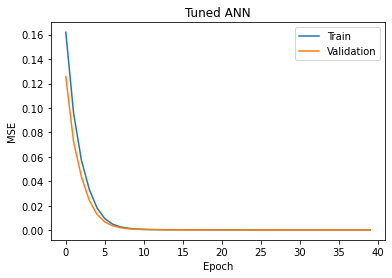

In [9]:
def visualising_data(hist, name):
    plt.title('Tuned ANN')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name)
    plt.show()
visualising_data(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results.png')

In [10]:
# shows weights of the ANN
# hypermodel.weights
hypermodel.summary()
# print(hypermodel.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 114)               4788      
_________________________________________________________________
dense_1 (Dense)              (None, 86)                9890      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3480      
Total params: 18,158
Trainable params: 18,158
Non-trainable params: 0
_________________________________________________________________


In [11]:
# INSERT SOMETHING THAT CALCUALTES ALL MEAN SQUARED ERRORS AND PLOTS ON CDF GRAPH

In [12]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')

# Transfer Learning

In [13]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
    hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [14]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 114)               4788      
_________________________________________________________________
dense_1 (Dense)              (None, 86)                9890      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3480      
Total params: 18,158
Trainable params: 18,158
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 114)               4788      
_________________________________________________________________
dense_1 (Dense)              (None, 86)                9890      
______________________________

In [15]:
start_time = time.time()
# new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=0)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
eval_result = model.evaluate(X_test, Y_test, verbose=0)
# evaluating OLD model with new data
hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(eval_result)
print(hypermodel_result)

24.3152859210968
[0.00012274991200926402, 0.00012274993]
[0.0006825056145898998, 0.00068250566]


In [16]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_EDFAs_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=0, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
value_new = model.evaluate(X_test, Y_test, verbose=0)
# evaluating new model
value_old = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(value_new)
print(value_old)

20.766396045684814
[0.00010581751441350206, 0.00010581752]
[0.0006379291953829428, 0.0006379293]
